# **BUILDING OFFLINE MODEL**

## **CREATING SPARK SESSION**

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## **LOADING AND PREPROCESSING DATA**

In [2]:
heartds=spark.read.csv('C:\heart.csv',header=True,inferSchema=True)
heartds.dropna()
heartds.printSchema()

root
 |-- AGE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- CPT: integer (nullable = true)
 |-- RBP: integer (nullable = true)
 |-- SCH: integer (nullable = true)
 |-- FBS: integer (nullable = true)
 |-- RES: integer (nullable = true)
 |-- MHR: integer (nullable = true)
 |-- EIA: integer (nullable = true)
 |-- OPK: double (nullable = true)
 |-- PES: integer (nullable = true)
 |-- VCA: integer (nullable = true)
 |-- THA: integer (nullable = true)
 |-- target: integer (nullable = true)



In [3]:
# !pip install numpy
from pyspark.ml.feature import VectorAssembler
cols=heartds.columns
cols.remove('target')
assembler=VectorAssembler(inputCols=cols,outputCol='features')
heartds=assembler.transform(heartds)
heartds.select('features').show(truncate=False)

+------------------------------------------------------------+
|features                                                    |
+------------------------------------------------------------+
|[63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0]|
|[37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0]|
|[41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0]|
|[56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0]|
|[57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0]|
|[57.0,1.0,0.0,140.0,192.0,0.0,1.0,148.0,0.0,0.4,1.0,0.0,1.0]|
|[56.0,0.0,1.0,140.0,294.0,0.0,0.0,153.0,0.0,1.3,1.0,0.0,2.0]|
|[44.0,1.0,1.0,120.0,263.0,0.0,1.0,173.0,0.0,0.0,2.0,0.0,3.0]|
|[52.0,1.0,2.0,172.0,199.0,1.0,1.0,162.0,0.0,0.5,2.0,0.0,3.0]|
|[57.0,1.0,2.0,150.0,168.0,0.0,1.0,174.0,0.0,1.6,2.0,0.0,2.0]|
|[54.0,1.0,0.0,140.0,239.0,0.0,1.0,160.0,0.0,1.2,2.0,0.0,2.0]|
|[48.0,0.0,2.0,130.0,275.0,0.0,1.0,139.0,0.0,0.2,2.0,0.0,2.0]|
|[49.0,1.0,1.0,130.0,266.0,0.0,1.0,171.0,0.0,0.6,2.0,0.

## **MinMax SCALER**

In [4]:
from pyspark.ml.feature import MinMaxScaler
scaler=MinMaxScaler(inputCol='features',outputCol='scaledfeatures')
scalermodel=scaler.fit(heartds)
heartds=scalermodel.transform(heartds)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
heartds.select("scaledfeatures",'target').show()

Features scaled to range: [0.000000, 1.000000]
+--------------------+------+
|      scaledfeatures|target|
+--------------------+------+
|[0.70833333333333...|     1|
|[0.16666666666666...|     1|
|[0.25,0.0,0.33333...|     1|
|[0.5625,1.0,0.333...|     1|
|[0.58333333333333...|     1|
|[0.58333333333333...|     1|
|[0.5625,0.0,0.333...|     1|
|[0.3125,1.0,0.333...|     1|
|[0.47916666666666...|     1|
|[0.58333333333333...|     1|
|[0.52083333333333...|     1|
|[0.39583333333333...|     1|
|[0.41666666666666...|     1|
|[0.72916666666666...|     1|
|[0.60416666666666...|     1|
|[0.4375,0.0,0.666...|     1|
|[0.60416666666666...|     1|
|[0.77083333333333...|     1|
|[0.29166666666666...|     1|
|[0.83333333333333...|     1|
+--------------------+------+
only showing top 20 rows



## **SPLITTING DATA**

In [5]:
train,test=heartds.randomSplit([0.9,0.1])

In [6]:
from pyspark.sql.types import DoubleType
train=train.withColumn('target',train['target'].cast(DoubleType()))
test=test.withColumn('target',test['target'].cast(DoubleType()))

## **ACCURACY CALCULATOR**

In [7]:
def accuracy(pred):
  pred.groupBy('target','prediction').count().show()
  tn=pred.filter('prediction=0 AND target=prediction').count()
  tp=pred.filter('prediction=1 AND target=prediction').count()
  fn=pred.filter('prediction=0 AND target<>prediction').count()
  fp=pred.filter('prediction=1 AND target<>prediction').count()
  acc=((tn+tp)/(tn+tp+fn+fp))*100
  print('Accuracy=%0.2f'%acc)

# **MACHINE LEARNING ON FULL FEATURES**

## **RANDOM FOREST**

In [11]:
from pyspark.ml.classification import RandomForestClassifier
rf=RandomForestClassifier(labelCol='target',featuresCol='scaledfeatures')
rfmodel=rf.fit(train)
rfpredict_train=rfmodel.transform(train)
rfpredict_test=rfmodel.transform(test)
accuracy(rfpredict_test)
print('maxdepth:',rfmodel.getOrDefault('maxDepth'))
print('maxBins:',rfmodel.getOrDefault('maxBins'))
print('numTrees:',rfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   14|
|   0.0|       1.0|    4|
|   1.0|       0.0|    1|
|   0.0|       0.0|    9|
+------+----------+-----+

Accuracy=82.14
maxdepth: 5
maxBins: 32
numTrees: 20


In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(rf.maxDepth,[2,3,4,5]).addGrid(rf.maxBins,[10,15,20,30,35,40]).addGrid(rf.numTrees,[20,30,40,45]).build()
cv=CrossValidator(estimator=rf,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
rfpredict_train=cvmodel.transform(train)
rfpredict_test=cvmodel.transform(test)
bestrfmodel=cvmodel.bestModel
accuracy(rfpredict_test)
print('Best maxdepth:',bestrfmodel.getOrDefault('maxDepth'))
print('Best maxBins:',bestrfmodel.getOrDefault('maxBins'))
print('best numTrees:',bestrfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   15|
|   0.0|       1.0|    3|
|   0.0|       0.0|   10|
+------+----------+-----+

Accuracy=89.29
Best maxdepth: 3
Best maxBins: 15
best numTrees: 45


In [13]:
modelpath="D:\model"
bestrfmodel.save(modelpath)

## **LOGISTIC REGRESSION**

In [14]:
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression(labelCol='target',featuresCol='scaledfeatures')
lrmodel=lr.fit(train)
lrpredict_train=lrmodel.transform(train)
lrpredict_test=lrmodel.transform(test)
accuracy(lrpredict_test)
print('regParam:',lrmodel.getOrDefault('regParam'))
print('maxIter:',lrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   15|
|   0.0|       1.0|    6|
|   0.0|       0.0|    7|
+------+----------+-----+

Accuracy=78.57
regParam: 0.0
maxIter: 100


In [15]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(lr.regParam,[0.1,0.01,0.2,0.3,0.4,0.5]).addGrid(lr.maxIter,[0,10,30,40,50,75,100]).build()
cv=CrossValidator(estimator=lr,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
lrpredict_train=cvmodel.transform(train)
lrpredict_test=cvmodel.transform(test)
bestlrmodel=cvmodel.bestModel
accuracy(lrpredict_test)
print('regParam:',bestlrmodel.getOrDefault('regParam'))
print('maxIter:',bestlrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   15|
|   0.0|       1.0|    5|
|   0.0|       0.0|    8|
+------+----------+-----+

Accuracy=82.14
regParam: 0.2
maxIter: 30


## **DECISION TREE**

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
dt=DecisionTreeClassifier(labelCol='target',featuresCol='scaledfeatures')
dtmodel=dt.fit(train)
dtpredict_train=dtmodel.transform(train)
dtpredict_test=dtmodel.transform(test)
accuracy(dtpredict_test)
print('maxdepth:',dtmodel.getOrDefault('maxDepth'))
print('maxBins:',dtmodel.getOrDefault('maxBins'))
print('impurity:',dtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   15|
|   0.0|       1.0|    5|
|   0.0|       0.0|    8|
+------+----------+-----+

Accuracy=82.14
maxdepth: 5
maxBins: 32
impurity: gini


In [17]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(dt.maxDepth,[2,3,4,5]).addGrid(dt.impurity,['entropy','gini']).addGrid(dt.maxBins,[10,15,20,30,35,40]).build()
cv=CrossValidator(estimator=dt,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
dtpredict_train=cvmodel.transform(train)
dtpredict_test=cvmodel.transform(test)
bestdtmodel=cvmodel.bestModel
accuracy(dtpredict_test)
print('maxdepth:',bestdtmodel.getOrDefault('maxDepth'))
print('maxBins:',bestdtmodel.getOrDefault('maxBins'))
print('impurity:',bestdtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   15|
|   0.0|       1.0|    4|
|   0.0|       0.0|    9|
+------+----------+-----+

Accuracy=85.71
maxdepth: 5
maxBins: 10
impurity: entropy


## **SVM**

In [18]:
from pyspark.ml.classification import LinearSVC
sv=LinearSVC(labelCol='target',featuresCol='scaledfeatures')
svmodel=sv.fit(train)
svpredict_train=svmodel.transform(train)
svpredict_test=svmodel.transform(test)
accuracy(svpredict_test)
print('regParam:',svmodel.getOrDefault('regParam'))
print('maxIter:',svmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   14|
|   0.0|       1.0|    5|
|   1.0|       0.0|    1|
|   0.0|       0.0|    8|
+------+----------+-----+

Accuracy=78.57
regParam: 0.0
maxIter: 100


In [19]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(sv.regParam,[0.01,0.02,0.03,0.1,0.2,0.3]).addGrid(sv.maxIter,[10,20,25,30,35,40,45,50]).build()
cv=CrossValidator(estimator=sv,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
svpredict_train=cvmodel.transform(train)
svpredict_test=cvmodel.transform(test)
bestsvmodel=cvmodel.bestModel
accuracy(svpredict_test)
print('regParam:',bestsvmodel.getOrDefault('regParam'))
print('maxIter:',bestsvmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   14|
|   0.0|       1.0|    5|
|   1.0|       0.0|    1|
|   0.0|       0.0|    8|
+------+----------+-----+

Accuracy=78.57
regParam: 0.1
maxIter: 35


## **ACCURACY COMPARISION**

In [1]:
ffaccuracy=[78.57,82.14,82.14,78.57]
hyperffaccuracy=[82.14,85.71,89.29,78.57]
bestffaccuracy=[82.14,85.71,89.29,78.57]
model=['lr','dt','rf','svm']
def graph(ax,model,acc):
  sns.set_style("dark")
  plt.xlabel('CLASSIFIERS')
  plt.ylabel('ACCURACY(%)')
  total=len(model)
  for i,j in enumerate(ax.patches):
    percentage= '{:.2f}%'.format(acc[i])
    x=j.get_x()+j.get_width()/2-0.25
    y=j.get_y()+j.get_height()+0.45
    ax.annotate(percentage,(x,y),size=12)
  plt.show()

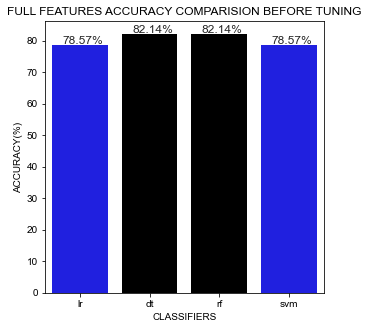

In [2]:
# !pip install matplotlib
# !pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(ffaccuracy) else 'black' for x in ffaccuracy]
ax=sns.barplot(x=model,y=ffaccuracy,palette=clrs)
plt.title('FULL FEATURES ACCURACY COMPARISION BEFORE TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,ffaccuracy)

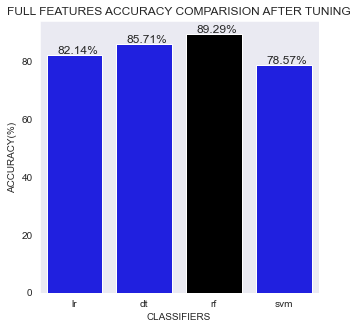

In [3]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(hyperffaccuracy) else 'black' for x in hyperffaccuracy]
ax=sns.barplot(x=model,y=hyperffaccuracy,palette=clrs)
plt.title('FULL FEATURES ACCURACY COMPARISION AFTER TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,hyperffaccuracy)

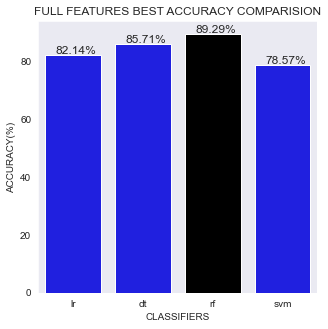

In [45]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(bestffaccuracy) else 'black' for x in bestffaccuracy]
ax=sns.barplot(x=model,y=bestffaccuracy,palette=clrs)
plt.title('FULL FEATURES BEST ACCURACY COMPARISION')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,bestffaccuracy)

## **FULL FEATURES BEST PARAMTERS**

MODEL| BEST PARAMETERS-FULL FEATURES
:- | :-
LR | regParam: 0.2, maxIter: 30
DT | impurity: entropy, maxDepth: 5, maxBins: 10
RF | maxDepth: 3, maxBins: 15, numTrees: 45
SVM| regParam: 0.1, maxIter: 35, kernel: Linear 

# **MACHINE LEARNING ON UNIVARIATE FEATURES**

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
heartds=spark.read.csv('C:\heart.csv',header=True,inferSchema=True)
heartds.dropna()
heartds.printSchema()

root
 |-- AGE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- CPT: integer (nullable = true)
 |-- RBP: integer (nullable = true)
 |-- SCH: integer (nullable = true)
 |-- FBS: integer (nullable = true)
 |-- RES: integer (nullable = true)
 |-- MHR: integer (nullable = true)
 |-- EIA: integer (nullable = true)
 |-- OPK: double (nullable = true)
 |-- PES: integer (nullable = true)
 |-- VCA: integer (nullable = true)
 |-- THA: integer (nullable = true)
 |-- target: integer (nullable = true)



In [16]:
heartds.toPandas().shape

(303, 14)

In [17]:
from pyspark.ml.feature import VectorAssembler
uf=['AGE', 'CPT', 'SCH', 'MHR', 'EIA', 'OPK', 'VCA']
rf=['THA', 'VCA', 'EIA', 'CPT', 'PES', 'OPK', 'MHR']
assembler=VectorAssembler(inputCols=uf,outputCol='unifeatures')
heartds=assembler.transform(heartds)
assembler=VectorAssembler(inputCols=rf,outputCol='relieffeatures')
heartds=assembler.transform(heartds)
heartds.select('unifeatures','relieffeatures').show(3)

+--------------------+--------------------+
|         unifeatures|      relieffeatures|
+--------------------+--------------------+
|[63.0,3.0,233.0,1...|[1.0,0.0,0.0,3.0,...|
|[37.0,2.0,250.0,1...|[2.0,0.0,0.0,2.0,...|
|[41.0,1.0,204.0,1...|[2.0,0.0,0.0,1.0,...|
+--------------------+--------------------+
only showing top 3 rows



In [19]:
from pyspark.ml.feature import MinMaxScaler
scaler=MinMaxScaler(inputCol='unifeatures',outputCol='scaledunifeatures')
scalermodel=scaler.fit(heartds)
heartds=scalermodel.transform(heartds)
heartds.select("scaledunifeatures",'target').show(3)

+--------------------+------+
|   scaledunifeatures|target|
+--------------------+------+
|[0.70833333333333...|     1|
|[0.16666666666666...|     1|
|[0.25,0.333333333...|     1|
+--------------------+------+
only showing top 3 rows



In [20]:
scaler=MinMaxScaler(inputCol='relieffeatures',outputCol='scaledrelieffeatures')
scalermodel=scaler.fit(heartds)
heartds=scalermodel.transform(heartds)
heartds.select("scaledrelieffeatures",'target').show(3)

+--------------------+------+
|scaledrelieffeatures|target|
+--------------------+------+
|[0.33333333333333...|     1|
|[0.66666666666666...|     1|
|[0.66666666666666...|     1|
+--------------------+------+
only showing top 3 rows



In [21]:
train,test=heartds.randomSplit([0.9,0.1])

In [22]:
from pyspark.sql.types import DoubleType
train=train.withColumn('target',train['target'].cast(DoubleType()))
test=test.withColumn('target',test['target'].cast(DoubleType()))

In [23]:
def accuracy(pred):
  pred.groupBy('target','prediction').count().show()
  tn=pred.filter('prediction=0 AND target=prediction').count()
  tp=pred.filter('prediction=1 AND target=prediction').count()
  fn=pred.filter('prediction=0 AND target<>prediction').count()
  fp=pred.filter('prediction=1 AND target<>prediction').count()
  acc=((tn+tp)/(tn+tp+fn+fp))*100
  print('Accuracy=%0.2f'%acc)

## **LOGISTIC REGRESSION**

In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

In [26]:
lr=LogisticRegression(labelCol='target',featuresCol='scaledunifeatures')
lrmodel=lr.fit(train)
lrpredict_train=lrmodel.transform(train)
lrpredict_test=lrmodel.transform(test)
accuracy(lrpredict_test)
print('regParam:',lrmodel.getOrDefault('regParam'))
print('maxIter:',lrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    2|
|   1.0|       0.0|    1|
|   0.0|       0.0|    6|
+------+----------+-----+

Accuracy=84.21
regParam: 0.0
maxIter: 100


In [27]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(lr.regParam,[0.1,0.01,0.2,0.3,0.4,0.5]).addGrid(lr.maxIter,[0,10,30,40,50,75,100]).build()
cv=CrossValidator(estimator=lr,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
lrpredict_train=cvmodel.transform(train)
lrpredict_test=cvmodel.transform(test)
bestlrmodel=cvmodel.bestModel
accuracy(lrpredict_test)
print('regParam:',bestlrmodel.getOrDefault('regParam'))
print('maxIter:',bestlrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    2|
|   1.0|       0.0|    1|
|   0.0|       0.0|    6|
+------+----------+-----+

Accuracy=84.21
regParam: 0.2
maxIter: 10


## **DECISION TREE**

In [28]:
dt=DecisionTreeClassifier(labelCol='target',featuresCol='scaledunifeatures')
dtmodel=dt.fit(train)
dtpredict_train=dtmodel.transform(train)
dtpredict_test=dtmodel.transform(test)
accuracy(dtpredict_test)
print('maxdepth:',dtmodel.getOrDefault('maxDepth'))
print('maxBins:',dtmodel.getOrDefault('maxBins'))
print('impurity:',dtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    6|
|   1.0|       0.0|    2|
|   0.0|       0.0|    2|
+------+----------+-----+

Accuracy=57.89
maxdepth: 5
maxBins: 32
impurity: gini


In [29]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(dt.maxDepth,[2,3,4,5]).addGrid(dt.impurity,['entropy','gini']).addGrid(dt.maxBins,[10,15,20,30,35,40]).build()
cv=CrossValidator(estimator=dt,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
dtpredict_train=cvmodel.transform(train)
dtpredict_test=cvmodel.transform(test)
bestdtmodel=cvmodel.bestModel
accuracy(dtpredict_test)
print('maxdepth:',bestdtmodel.getOrDefault('maxDepth'))
print('maxBins:',bestdtmodel.getOrDefault('maxBins'))
print('impurity:',bestdtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    6|
|   1.0|       0.0|    1|
|   0.0|       0.0|    2|
+------+----------+-----+

Accuracy=63.16
maxdepth: 4
maxBins: 35
impurity: entropy


## **RANDOM FOREST**

In [31]:
rf=RandomForestClassifier(labelCol='target',featuresCol='scaledunifeatures')
rfmodel=rf.fit(train)
rfpredict_train=rfmodel.transform(train)
rfpredict_test=rfmodel.transform(test)
accuracy(rfpredict_test)
print('maxdepth:',rfmodel.getOrDefault('maxDepth'))
print('maxBins:',rfmodel.getOrDefault('maxBins'))
print('numTrees:',rfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    3|
|   1.0|       0.0|    1|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=78.95
maxdepth: 5
maxBins: 32
numTrees: 20


In [32]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(rf.maxDepth,[2,3,4,5]).addGrid(rf.maxBins,[10,15,20,30,35,40]).addGrid(rf.numTrees,[20,30,35,40]).addGrid(rf.impurity,['entropy','gini']).build()
cv=CrossValidator(estimator=rf,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
rfpredict_train=cvmodel.transform(train)
rfpredict_test=cvmodel.transform(test)
bestrfmodel=cvmodel.bestModel
accuracy(rfpredict_test)
print('Best maxdepth:',bestrfmodel.getOrDefault('maxDepth'))
print('Best maxBins:',bestrfmodel.getOrDefault('maxBins'))
print('best numTrees:',bestrfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    3|
|   1.0|       0.0|    1|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=78.95
Best maxdepth: 4
Best maxBins: 10
best numTrees: 35


## **SVM**

In [33]:
sv=LinearSVC(labelCol='target',featuresCol='scaledunifeatures')
svmodel=sv.fit(train)
svpredict_train=svmodel.transform(train)
svpredict_test=svmodel.transform(test)
accuracy(svpredict_test)
print('regParam:',svmodel.getOrDefault('regParam'))
print('maxIter:',svmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    2|
|   1.0|       0.0|    1|
|   0.0|       0.0|    6|
+------+----------+-----+

Accuracy=84.21
regParam: 0.0
maxIter: 100


In [34]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(sv.regParam,[0.01,0.02,0.03,0.1,0.2,0.3]).addGrid(sv.maxIter,[10,20,25,30,35,40,45,50]).build()
cv=CrossValidator(estimator=sv,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
svpredict_train=cvmodel.transform(train)
svpredict_test=cvmodel.transform(test)
bestsvmodel=cvmodel.bestModel
accuracy(svpredict_test)
print('regParam:',bestsvmodel.getOrDefault('regParam'))
print('maxIter:',bestsvmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    3|
|   1.0|       0.0|    1|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=78.95
regParam: 0.3
maxIter: 20


## **ACCURACY COMPARISION**

In [48]:
ufaccuracy=[84.21,57.89,78.95,84.21]
hyperufaccuracy=[84.21,63.16,78.95,78.95]
bestufaccuracy=[82.21,63.16,78.95,84.21]

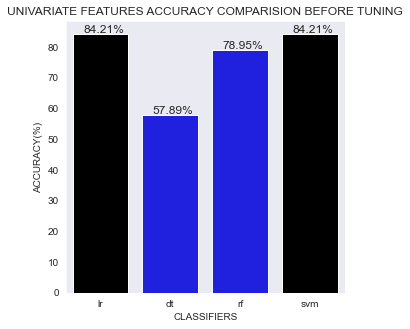

In [49]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(ufaccuracy) else 'black' for x in ufaccuracy]
ax=sns.barplot(x=model,y=ufaccuracy,palette=clrs)
plt.title('UNIVARIATE FEATURES ACCURACY COMPARISION BEFORE TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,ufaccuracy)

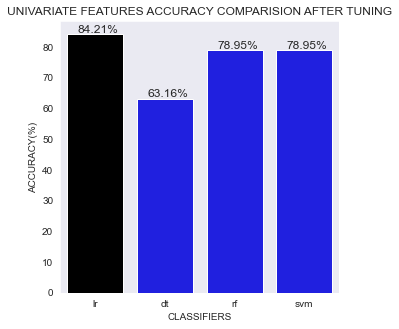

In [50]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(hyperufaccuracy) else 'black' for x in hyperufaccuracy]
ax=sns.barplot(x=model,y=hyperufaccuracy,palette=clrs)
plt.title('UNIVARIATE FEATURES ACCURACY COMPARISION AFTER TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,hyperufaccuracy)

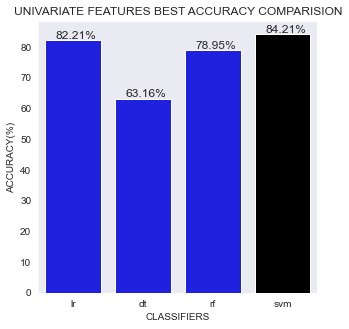

In [54]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(bestufaccuracy) else 'black' for x in bestufaccuracy]
ax=sns.barplot(x=model,y=bestufaccuracy,palette=clrs)
plt.title('UNIVARIATE FEATURES BEST ACCURACY COMPARISION')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,bestufaccuracy)

## **UNIVARIATE FEATURES BEST PARAMTERS**

MODEL| BEST PARAMETERS-UNIVARIATE FEATURES
:- | :-
LR | regParam: 0.2, maxIter: 10
DT | impurity: entropy, maxDepth: 4, maxBins: 35
RF | maxDepth: 4, maxBins: 10, numTrees: 35
SVM| regParam: 0, maxIter: 100, kernel: Linear 

# **MACHINE LEARNING ON RELIEF FEATURES**

## **LOGISTIC REGRESSION**

In [35]:
lr=LogisticRegression(labelCol='target',featuresCol='scaledrelieffeatures')
lrmodel=lr.fit(train)
lrpredict_train=lrmodel.transform(train)
lrpredict_test=lrmodel.transform(test)
accuracy(lrpredict_test)
print('regParam:',lrmodel.getOrDefault('regParam'))
print('maxIter:',lrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    2|
|   1.0|       0.0|    2|
|   0.0|       0.0|    6|
+------+----------+-----+

Accuracy=78.95
regParam: 0.0
maxIter: 100


In [36]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(lr.regParam,[0.1,0.01,0.2,0.3,0.4,0.5]).addGrid(lr.maxIter,[0,10,30,40,50,75,100]).build()
cv=CrossValidator(estimator=lr,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
lrpredict_train=cvmodel.transform(train)
lrpredict_test=cvmodel.transform(test)
bestlrmodel=cvmodel.bestModel
accuracy(lrpredict_test)
print('regParam:',bestlrmodel.getOrDefault('regParam'))
print('maxIter:',bestlrmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    3|
|   1.0|       0.0|    1|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=78.95
regParam: 0.3
maxIter: 10


## **DECISION TREE**

In [37]:
dt=DecisionTreeClassifier(labelCol='target',featuresCol='scaledrelieffeatures')
dtmodel=dt.fit(train)
dtpredict_train=dtmodel.transform(train)
dtpredict_test=dtmodel.transform(test)
accuracy(dtpredict_test)
print('maxdepth:',dtmodel.getOrDefault('maxDepth'))
print('maxBins:',dtmodel.getOrDefault('maxBins'))
print('impurity:',dtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    4|
|   1.0|       0.0|    2|
|   0.0|       0.0|    4|
+------+----------+-----+

Accuracy=68.42
maxdepth: 5
maxBins: 32
impurity: gini


In [38]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(dt.maxDepth,[2,3,4,5]).addGrid(dt.impurity,['entropy','gini']).addGrid(dt.maxBins,[10,15,20,30,35,40]).build()
cv=CrossValidator(estimator=dt,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
dtpredict_train=cvmodel.transform(train)
dtpredict_test=cvmodel.transform(test)
bestdtmodel=cvmodel.bestModel
accuracy(dtpredict_test)
print('maxdepth:',bestdtmodel.getOrDefault('maxDepth'))
print('maxBins:',bestdtmodel.getOrDefault('maxBins'))
print('impurity:',bestdtmodel.getOrDefault('impurity'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    2|
|   1.0|       0.0|    2|
|   0.0|       0.0|    6|
+------+----------+-----+

Accuracy=78.95
maxdepth: 5
maxBins: 10
impurity: entropy


## **RANDOM FOREST**

In [39]:
rf=RandomForestClassifier(labelCol='target',featuresCol='scaledrelieffeatures')
rfmodel=rf.fit(train)
rfpredict_train=rfmodel.transform(train)
rfpredict_test=rfmodel.transform(test)
accuracy(rfpredict_test)
print('maxdepth:',rfmodel.getOrDefault('maxDepth'))
print('maxBins:',rfmodel.getOrDefault('maxBins'))
print('numTrees:',rfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    3|
|   1.0|       0.0|    2|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=73.68
maxdepth: 5
maxBins: 32
numTrees: 20


In [40]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(rf.maxDepth,[2,3,4,5]).addGrid(rf.maxBins,[10,15,20,30,35,40]).addGrid(rf.numTrees,[20,30,35,40]).addGrid(rf.impurity,['entropy','gini']).build()
cv=CrossValidator(estimator=rf,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
rfpredict_train=cvmodel.transform(train)
rfpredict_test=cvmodel.transform(test)
bestrfmodel=cvmodel.bestModel
accuracy(rfpredict_test)
print('Best maxdepth:',bestrfmodel.getOrDefault('maxDepth'))
print('Best maxBins:',bestrfmodel.getOrDefault('maxBins'))
print('best numTrees:',bestrfmodel.getOrDefault('numTrees'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    4|
|   1.0|       0.0|    2|
|   0.0|       0.0|    4|
+------+----------+-----+

Accuracy=68.42
Best maxdepth: 3
Best maxBins: 10
best numTrees: 35


## **SVM**

In [41]:
sv=LinearSVC(labelCol='target',featuresCol='scaledrelieffeatures')
svmodel=sv.fit(train)
svpredict_train=svmodel.transform(train)
svpredict_test=svmodel.transform(test)
accuracy(svpredict_test)
print('regParam:',svmodel.getOrDefault('regParam'))
print('maxIter:',svmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|    9|
|   0.0|       1.0|    3|
|   1.0|       0.0|    2|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=73.68
regParam: 0.0
maxIter: 100


In [42]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='target')
paramgrid=ParamGridBuilder().addGrid(sv.regParam,[0.01,0.02,0.03,0.1,0.2,0.3]).addGrid(sv.maxIter,[10,20,25,30,35,40,45,50]).build()
cv=CrossValidator(estimator=sv,estimatorParamMaps=paramgrid,evaluator=evaluator,numFolds=10)
cvmodel=cv.fit(train)
svpredict_train=cvmodel.transform(train)
svpredict_test=cvmodel.transform(test)
bestsvmodel=cvmodel.bestModel
accuracy(svpredict_test)
print('regParam:',bestsvmodel.getOrDefault('regParam'))
print('maxIter:',bestsvmodel.getOrDefault('maxIter'))

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|   1.0|       1.0|   10|
|   0.0|       1.0|    3|
|   1.0|       0.0|    1|
|   0.0|       0.0|    5|
+------+----------+-----+

Accuracy=78.95
regParam: 0.2
maxIter: 10


## **ACCURACY COMPARSION**

In [55]:
rfaccuracy=[78.95,68.42,73.68,73.68]
hyperrfaccuracy=[78.95,78.95,68.42,78.95]
bestrfaccuracy=[78.95,78.95,73.68,78.95]

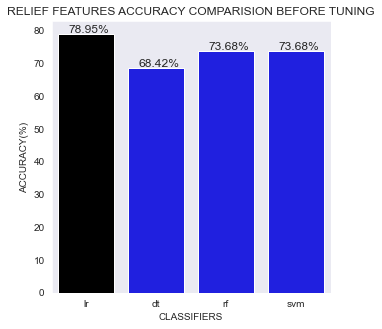

In [56]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(rfaccuracy) else 'black' for x in rfaccuracy]
ax=sns.barplot(x=model,y=rfaccuracy,palette=clrs)
plt.title('RELIEF FEATURES ACCURACY COMPARISION BEFORE TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,rfaccuracy)

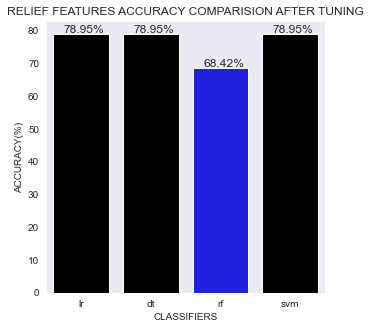

In [57]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(hyperrfaccuracy) else 'black' for x in hyperrfaccuracy]
ax=sns.barplot(x=model,y=hyperrfaccuracy,palette=clrs)
plt.title('RELIEF FEATURES ACCURACY COMPARISION AFTER TUNING')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,hyperrfaccuracy)

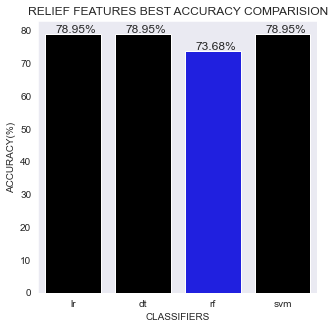

In [58]:
plt.subplots(figsize=(5,5))
clrs=['blue' if x<max(bestrfaccuracy) else 'black' for x in bestrfaccuracy]
ax=sns.barplot(x=model,y=bestrfaccuracy,palette=clrs)
plt.title('RELIEF FEATURES BEST ACCURACY COMPARISION')
plt.xlabel('CLASSIFIERS')
plt.ylabel('ACCURACY(%)')
graph(ax,model,bestrfaccuracy)

## **RELIEF FEATURES BEST PARAMTERS**

MODEL| BEST PARAMETERS-RELIEF FAETURES
:- | :-
LR | regParam: 0.3, maxIter: 10
DT | impurity: entropy, maxDepth: 5, maxBins: 10
RF | maxDepth: 5, maxBins: 32, numTrees: 20
SVM| regParam: 0.2, maxIter: 10, kernel: Linear 